In [ ]:
from tqdm import tqdm
tqdm.pandas()
from glob import glob

import json
import csv
import numpy as np
import pandas as pd
from collections import Counter

import rdflib
from rdflib import Graph
from data.data import CollectionAccessor, ImageHandler

from search import Search, Randomiser

In [ ]:
def init_DMG(images_path):
    if images_path is not None:
        image_handler = ImageHandler(image_folder=images_path, keep_prefix=True)
    else:
        image_handler = None

    time_stamp, pub_file, priv_file = CollectionAccessor.get_latest_dump("./data/dumps")
    # print(CollectionAccessor.get_latest_dump("./data/dumps"))

    
    dmg_meta = dict(name="Design Museum Gent (public & private)", id_="DMG_"+time_stamp,
                creation_timestamp=time_stamp)
    df = CollectionAccessor.get_DMG(pub_path=pub_file, #get_latest("./data/dumps", contains="public"),
                                     priv_path=priv_file, #get_latest("./data/dumps", contains="private"),
                                     rights_path="./data/rights.csv",
                                     image_handler=image_handler,
                                     **dmg_meta)
    return image_handler, df

image_handler, dmg = init_DMG("./data/images/")

In [ ]:
dmg.image_path.fillna(False).apply(lambda ls: (ls[0] if ls else None))

In [ ]:
def init_DMG():
    image_folder = "./data/images/DMG"
    image_handler = ImageHandler(image_folder=image_folder, keep_prefix=False)
    print("image paths loaded...")

    time_stamp, pub_file, priv_file = CollectionAccessor.get_latest_dump("./data/dumps")
    print(CollectionAccessor.get_latest_dump("./data/dumps"))

    
    dmg_meta = dict(name="Design Museum Gent (public & private)", id_="DMG_"+time_stamp,
                creation_timestamp=time_stamp)
    df = CollectionAccessor.get_DMG(pub_path=pub_file, #get_latest("./data/dumps", contains="public"),
                                     priv_path=priv_file, #get_latest("./data/dumps", contains="private"),
                                     rights_path="./data/rights.csv",
                                     image_handler=image_handler,
                                     **dmg_meta)
    
    rand = Randomiser(df, name="Randomiser")
    rand2 = Randomiser(df, name="Randomiser")
    s = Search([rand, rand2])
    return image_handler, df, s

im, dmg, dmg_search = init_DMG()

In [ ]:
recs = dmg.sample(4)
searcher_ids = [s.id for s in dmg_search.searchers[:1]]

In [ ]:
dmg_search(recs, searcher_ids=searcher_ids)

---
# DEV FUNCTIONS

In [ ]:
def search_collection(collection_id, object_ids, concept, model_list):
    cur_coll = get_collection(collection_id)
    object_ids = parse_id_list(object_ids)
    model_list = parse_id_list(model_list)
    cur_search = searches[collection_id]
    print(object_ids)
    scores = cur_search(object_ids)


object_ids = "1987-0120_04-14,1987-1343_2-4,3370,3703_0-2"
object_ids = parse_id_list(object_ids)
object_ids
recs = dmg.loc[object_ids]

In [ ]:
# searcher_scores = [cur_s(recs) for cur_s in dmg_search.searchers]
# searcher_scores = pd.DataFrame({cur_s.name: cur_s for cur_s in searcher_scores})
# searcher_scores.loc[recs.index] = 0.


# searcher_scores.round(3)

In [ ]:


dmg.coll.filter("doos")

---
# TESTING ROUTES

In [ ]:
!curl "http://0.0.0.0:8080/collections"

In [ ]:
!curl "http://0.0.0.0:8080/DMG_2025-05-13"

In [ ]:
!curl "http://0.0.0.0:8080/DMG_2025-05-13/object-details?object_ids=1987-0120_04-14,1987-1343_2-4,3370,3703_0-2"

In [ ]:
!curl "http://0.0.0.0:8080/DMG_2025-05-13/models"

In [ ]:
!curl "http://0.0.0.0:8080/moon?ISO_8601_datetime=2024-05-13&lat_degrees=51.05&long_degrees=3.71"

In [ ]:
# default params for search
!curl "http://0.0.0.0:8080/DMG_2025-05-13/search"

In [ ]:
!curl "http://0.0.0.0:8080/DMG_2025-05-13/search?object_ids="1987-0120_04-14,1987-1343_2-4,3370,3703_0-2"&concept="schreeuw"&model_list="""

In [ ]:
!curl "http://0.0.0.0:8080/DMG_2025-05-13/search/order?object_ids="1987-0120_04-14,1987-1343_2-4,3370,3703_0-2"&concept="hello"&model_list="a,b"&skip=200&limit=100&reverse=true"

In [ ]:
!curl "http://0.0.0.0:8080/DMG_2025-05-13/search/sample?object_ids="1987-0120_04-14,1987-1343_2-4,3370,3703_0-2"&concept="hello"&model_list="a,b"&k=12"

In [ ]:
!curl "http://0.0.0.0:8080/DMG_2025-05-13/search/order/filter?object_ids="1987-0120_04-14,1987-1343_2-4,3370,3703_0-2"&concept="hello"&model_ids=""&filter_text="doosje""

---

# routes 2

In [39]:
import requests as rq
from time import time
from tqdm import tqdm
import pandas as pd

base = "http://0.0.0.0:8080/"
# collection_id="DMG_2025-05-13/"

In [40]:
# path = "search/sample"
scores = []
for d in rq.get(base+"/collections").json():
    collection_id = d["id"] +"/"
    print(collection_id)
    models = pd.DataFrame.from_records(rq.get(base+collection_id+"models").json())
    # models = models[models.name.str.startswith("Visual")]
    
    params = dict(object_ids="", concept="", model_ids=",".join(models.id)) #,".join(models))
    search_res = rq.get(base+collection_id+"search/sample", params).json()
    # scores.append(pd.Series(search_res).sort_values())
    first_sample = pd.DataFrame.from_records(search_res).sample(4)

    params = dict(object_ids=",".join(first_sample.inventory_number), 
                  concept="", model_ids=",".join(models.id)) #,".join(models))
    try:
        search_res = pd.DataFrame.from_records(rq.get(base+collection_id+"search/order/filter", params).json())
    except Exception as e:
        print(e)
        print("oops")

    # score_ls.append(scores)

    # print(rq.get(base+coll_id+"/models").json())
    

DMG_2025-06-06/
MKG_2025-06-05/


In [ ]:
pd.Series(rq.get(base+collection_id+"search", params).json())

<Axes: >

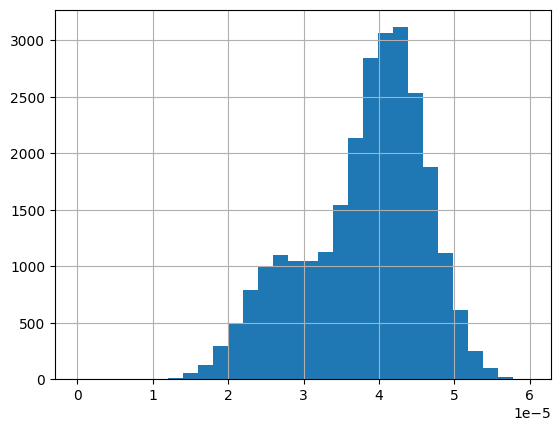

In [10]:
search_res.hist(bins=30)

In [ ]:
pd.Series(search_res)

In [ ]:
path = "search/order"
models = rq.get(base+collection_id+"models").json()
models = [d["id"] for d in models]
params = dict(object_ids="IE1896.152,O1912.472,1984.496,O1911.243", concept="", model_ids=",".join(models))
search_res = rq.get(base+collection_id+path, params).json()
# pd.Series(search_res).hist()

In [ ]:
pd.DataFrame.from_records(search_res)

In [ ]:
path = "models"
models = rq.get(base+collection_id+path).json()
models = [m["id"] for m in models]
models

In [ ]:
dmg.coll.filter("stoel")
# dmg.loc[["1999-0032_03-15"]].coll.get_texts()

In [ ]:
path = "search/order"

params = dict(object_ids="3535", concept="stoel", model_ids=",".join(models))
search_res = rq.get(base+collection_id+path, params).json()
# scores = pd.Series(search_res).sort_values()


print("\n".join(pd.DataFrame.from_records(search_res).title[:10]))

In [ ]:
score_ls = []
path = "search"
for m in models:
    print(parse_id_list(m))
    params = dict(object_ids="1999-0032_03-15", concept="", model_ids=m) #,".join(models))
    search_res = rq.get(base+collection_id+path, params).json()
    scores = pd.Series(search_res).sort_values()
    score_ls.append(scores)
    print(scores.index[-10:])


params = dict(object_ids="", concept="meubel", model_ids="") #,".join(models))
search_res = rq.get(base+collection_id+path, params).json()
scores = pd.Series(search_res).sort_values()
score_ls.append(scores)


In [ ]:
# dmg.loc[scores.sort_values()[-10:].index]
# dmg.coll.order(scores)
pd.DataFrame.from_records(search_res)



In [ ]:
dmg.loc["2003-0147_2-2"]

In [ ]:

models = rq.get("http://0.0.0.0:8080/DMG_2025-05-13/models").json()
models = [d["id"] for d in models]

# for d in range(10, 30):
#     q = dict(ISO_8601_datetime=f"2024-05-{d}", 
#              lat_long_degrees="51.05,3.71")
timings = []
for _ in tqdm(range(100)):
    q = dict(object_ids="2015-0130,1987-1343_2-4,2001-0086,3703_0-2",
                 concept="twee halskettingen, deze zitten samen in 1 doosje",
                 model_list=",".join(models))
    
    # print(base+collection_id+path)
    # print(q)
    
    t0 = time()
    
    resp = rq.get(base+collection_id+path, params=q)
        
    resp.json()
    
    # print(time() - t0)
    timings.append(time() - t0)

In [ ]:
import pandas as pd
pd.Series(timings).hist(bins=40)

---
## fixing index issues

In [ ]:
collection_id = "DMG_2025-06-06/" #/search/order"

models = pd.DataFrame.from_records(rq.get(base+collection_id+"models").json())
models = models[models.name.str.startswith("Visual")]
    
# params = dict(object_ids="", concept="", model_ids=",".join(models.id)) #,".join(models))
# search_res = rq.get(base+collection_id+"search/order", params).json()

params = dict(object_ids="", concept="", model_ids=",".join(models.id)) #,".join(models))
scores = pd.Series(rq.get(base+collection_id+"search", params).json())

In [14]:
from data.data import ImageHandler, CollectionAccessor

def init_DMG():
    DMG_DIR = "./data/DMG"
    image_folder = DMG_DIR+"/images"
    image_handler = ImageHandler("DMG", image_folder=image_folder, keep_prefix=False)

    time_stamp, pub_file, priv_file = CollectionAccessor.get_latest_dump(DMG_DIR+"/dumps")


    dmg_meta = dict(name="Design Museum Gent (public & private)", id_="DMG_"+time_stamp,
                creation_timestamp=time_stamp, language="nl")
    df = CollectionAccessor.get_DMG(pub_path=pub_file, #get_latest("./data/dumps", contains="public"),
                                     priv_path=priv_file, #get_latest("./data/dumps", contains="private"),
                                     rights_path=DMG_DIR+"/rights.csv",
                                     image_handler=image_handler,
                                     **dmg_meta)

    # kg_searcher = GraphSearcher(df)


    # sem_embs = EmbeddingSpaceAccessor.load(DMG_DIR+"/generated_data/distiluse-base-multilingual-cased-v2",
    #                                    loadXD=None)
    # concept_search = TextEmbeddingSearcher(sem_embs, name="ConceptSearcher")


    # sem_embs = EmbeddingSpaceAccessor.load(DMG_DIR+"/generated_data/distiluse-base-multilingual-cased-v2",
    #                                    loadXD=32)
    # sem_searcher = EmbeddingSearcher(sem_embs, name="SemanticSearcher")
    
    # viz_embs = EmbeddingSpaceAccessor.load(DMG_DIR+"/generated_data/vitmae", loadXD=32)
    # viz_searcher = EmbeddingSearcher(viz_embs, name="VisualSearcher")

    # s = Search([kg_searcher, sem_searcher, viz_searcher])
    return df#, s, concept_search

dmg = init_DMG()

/home/valentin/home2-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|███████████████████████████████████████████████████████████████████████| 24781/24781 [00:19<00:00, 1302.92it/s]


In [ ]:
# dmg.loc["1992-0193_03-16_ARCHIEF"]

dmg[dmg.index.str.contains("ARCHIEF")]#.sum()

In [ ]:
scores.index.str.contains("ARCHIEF").sum()

dmg.index.difference(scores.index)

# scores.loc[dmg.index].shape, scores.shape
scores.loc[dmgs.index.intersection(scores.index)]


In [ ]:
a= pd.Series([1,2,3], index="a b c".split(), name="a")
b = pd.Series([1,2,3], index="b e f".split(), name="b")


pd.DataFrame({s.name: s for s in [a,b]})

---
## fixing list columns

In [15]:
def init_MKG():
    MKG_DIR = "./data/MKG"
    image_folder = MKG_DIR+"/images"
    image_handler = ImageHandler("MKG", image_folder=image_folder, keep_prefix=False)

    # time_stamp, pub_file, priv_file = CollectionAccessor.get_latest_dump("./data/dumps")

    time_stamp = "2025-06-05"
    mkg_meta = dict(name="Museum Kunst & Gewerbe", id_="MKG_"+time_stamp,
                    creation_timestamp=time_stamp, language="de")
    df = CollectionAccessor.get_MKG(metadata_path=MKG_DIR+"/dumps/extraction_v0_1.csv",
                                    image_handler=image_handler,
                                    **mkg_meta)
    return df

mkg = init_MKG()

100%|███████████████████████████████████████████████████████████████████████| 26294/26294 [00:16<00:00, 1588.32it/s]


In [38]:
mkg.coll.list_cols
text_search_fields = ["objectname_label", "material_label", "maker_label", "coiner_label"]
        
# text_matches = []
# for c in text_search_fields:
#     cur_col = self._obj[c].apply(lambda ls: " ".join(ls)) if c in self.list_cols else self._obj[c]


def join_lists(x):
    # if "coiner_label" in mkg.coll.list_cols:
    try:
        return " ".join(x)
    except TypeError:
        print(x)    
    # else self._obj[c]
    
mkg.material_label.fillna("").apply(join_lists)

"objectname_label" in mkg.coll.list_cols

True